In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter, OrderedDict
import json

Using TensorFlow backend.


## 1. Load Flickr8k dataset

In [2]:
caption_file = 'Flickr8k_text/Flickr8k.token.txt'
img2captions = {}
for row in open(caption_file):
    row = row.strip()
    row = row.split('\t')
    img = row[0][:len(row[0])-2]
    cap = row[1].lower()
    if img not in img2captions:
        img2captions[img] = []
    img2captions[img].append(cap)

In [4]:
images_dir = 'Flicker8k_Dataset/'
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_imgs = [line.strip() for line in open(train_images_file)]
print(len(train_imgs), train_imgs[:3])

val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_imgs = [line.strip() for line in open(val_images_file)]
print(len(val_imgs), val_imgs[:3])

test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_imgs = [line.strip() for line in open(test_images_file)]
print(len(test_imgs), test_imgs[:3])

(6000, ['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg'])
(1000, ['2090545563_a4e66ec76b.jpg', '3393035454_2d2370ffd4.jpg', '3695064885_a6922f06b2.jpg'])
(1000, ['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg', '311146855_0b65fdb169.jpg'])


a black dog is running after a white dog in the snow .
black dog chasing brown dog through snow
two dogs chase each other across the snowy ground .
two dogs play together in the snow .
two dogs running through a low lying body of water .


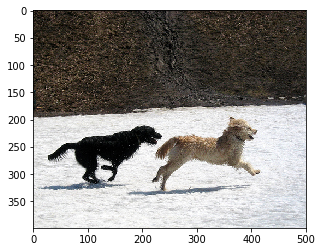

In [5]:
img = train_imgs[0]
plt.imshow(Image.open(images_dir + '/' + img))
print('\n'.join(img2captions[img]))

## 2. Build vocabulary

In [6]:
from collections import Counter, OrderedDict
import json

word_counter = Counter()
n_sample = 0
maxlen = 0
for img, captions in img2captions.items():
    for caption in captions:
        n_sample += 1
        caption = caption.lower()
        caption = str(caption)
        tokens = caption.split()
        maxlen = max([maxlen,len(tokens)])
        word_counter.update(tokens)
print('number of sample = ' + str(n_sample))
print('max len = ' + str(maxlen))


word_counts = [x for x in word_counter.items()]
word_counts.sort(key=lambda x: x[1], reverse=True)
json.dump(word_counts, open('word_counts.json', "w"), indent=2)

vocab = [w for w, c in word_counts if c >= 1]
start_word = '<start>'
end_word = '<end>'
vocab = [start_word, end_word] + vocab
print('vocabulary size = %d'%len(vocab))

word2idx = OrderedDict(zip(vocab,range(len(vocab))))
idx2word = OrderedDict(zip(range(len(vocab)), vocab))
json.dump(word2idx, open('word2idx.json', 'w'), indent=2)

number of sample = 40460
max len = 38
vocabulary size = 8920


## 3. Extract features for images

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [7]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [8]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

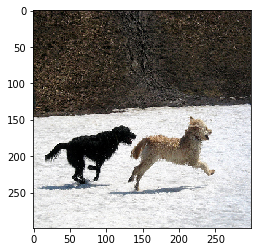

In [9]:
plt.imshow((1 + np.squeeze(preprocess(images_dir + '/' + train_imgs[0])))/2.0)

In [10]:
model = InceptionV3(weights='imagenet')

In [112]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [12]:
tryi = model_new.predict(preprocess(images_dir + '/' + train_imgs[0]))

In [13]:
tryi.shape

(1, 2048)

In [14]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [26]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
with open("encoded_images_train_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

100%|██████████| 6000/6000 [03:38<00:00, 27.52it/s]


In [30]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

100%|██████████| 1000/1000 [00:37<00:00, 26.72it/s]


In [15]:
encoding_train = pickle.load(open('encoded_images_train_inceptionV3.p', 'rb'))
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

## 4. Preprocess the captions
Adding '< start >' and '< end >' to all the captions to indicate the starting and ending of a sentence.

In [16]:
f = open('flickr8k_train_dataset.txt', 'w')
f.write("image_id\tcaptions\n")
for img in train_imgs:
    for cap in img2captions[img]:
        f.write(img + "\t" + "<start> " + cap +" <end>" + "\n")

f.close()

In [17]:
f = open('flickr8k_val_dataset.txt', 'w')
f.write("image_id\tcaptions\n")
for img in val_imgs:
    for cap in img2captions[img]:
        f.write(img + "\t" + "<start> " + cap +" <end>" + "\n")
f.close()

In [18]:
f = open('flickr8k_test_dataset.txt', 'w')
f.write("image_id\tcaptions\n")
for img in test_imgs:
    for cap in img2captions[img]:
        f.write(img + "\t" + "<start> " + cap +" <end>" + "\n")
f.close()

In [19]:
df = pd.read_csv('flickr8k_train_dataset.txt', delimiter='\t')

In [20]:
len(df)

30000

In [21]:
c = [i for i in df['captions']]
len(c)

30000

In [22]:
imgs = [i for i in df['image_id']]

In [23]:
a = c[-1]
a, imgs[-1]

('<start> the girl in the bathing suit is poised in midair next to the blue water . <end>',
 '2671602981_4edde92658.jpg')

In [24]:
for i in a.split():
    print (i, "=>", word2idx[i])

('<start>', '=>', 0)
('the', '=>', 5)
('girl', '=>', 19)
('in', '=>', 4)
('the', '=>', 5)
('bathing', '=>', 373)
('suit', '=>', 224)
('is', '=>', 7)
('poised', '=>', 3385)
('in', '=>', 4)
('midair', '=>', 243)
('next', '=>', 86)
('to', '=>', 21)
('the', '=>', 5)
('blue', '=>', 31)
('water', '=>', 25)
('.', '=>', 3)
('<end>', '=>', 1)


In [25]:
samples_per_epoch = 0
for cap in df['captions']:
    samples_per_epoch += len(cap.split())-1
print(samples_per_epoch)

383454


## 5. Data generator

In [117]:
max_len = 40
vocab_size = len(word2idx)
def data_generator(batch_size = 128, split='train'):
        partial_caps = []
        next_words = []
        images = []
        
        csv_file = 'flickr8k_%s_dataset.txt'%split
        encoding_img_feat = pickle.load(open('encoded_images_%s_inceptionV3.p'%split, 'rb'))
        df = pd.read_csv(csv_file, delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_img_feat[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

                        
train_set = data_generator(split='train')
val_set = data_generator(split='val')
test_set = data_generator(split='test')

image, littele girl running in field

X1,		X2 (text sequence), 						y (word)
image	< start >, 									little

image	< start >, little,							girl

image	< start >, little, girl, 					running

image	< start >, little, girl, running, 			in

image	< start >, little, girl, running, in, 		field

image	< start >, little, girl, running, in, field,  < end >


In [118]:
x = next(train_set)
print(x[0][0].shape)
print(x[0][1][:3])
print(np.argmax(x[1][:10], axis=1))
print(x[0][0][:10])

(128, 2048)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13 57  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
[  13   57 1995 1477  904    6    5 1134   79   24]
[[0.6075466  0.4298726  0.66388035 ... 0.11393655 0.53518224 0.20500459]
 [0.6075466  0.4298726  0.66388035 ... 0.11393655 0.53518224 0.20500459]
 [0.6075466  0.4298726  0.66388035 ... 0.11393655 0.53518224 0.20500459]
 ...
 [0.6075466  0.4298726  0.66388035 ... 0.11393655 0.53518224 0.20500459]
 [0.6075466  0.4298726  0.66388035 ... 0.11393655 0.53518224 0.20500459]
 [0.6075466  0.4298726  0.66388035 ... 0.11393655 0.53518224 0.20500459]]


## 6. Build the model

In [107]:
embedding_size = 300
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(1)
    ])
word_embedding_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        TimeDistributed(Dense(embedding_size, activation='relu'))
    ])
final_model = Sequential([
        Merge([image_model, word_embedding_model], mode='concat', concat_axis=1),
        LSTM(256, return_sequences=False),
        Dense(vocab_size),
        Activation('softmax')
    ])

from keras.optimizers import Adam, RMSprop
final_model.summary()
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_12 (Merge)             (None, 41, 300)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dense_36 (Dense)             (None, 8920)              2292440   
_________________________________________________________________
activation_106 (Activation)  (None, 8920)              0         
Total params: 6,243,808
Trainable params: 6,243,808
Non-trainable params: 0
_________________________________________________________________


In [89]:
batch_size = 256
steps_per_epoch = samples_per_epoch // batch_size
final_model.fit_generator(train_set, 
                          steps_per_epoch=steps_per_epoch, 
                          epochs=30,
                          verbose=2)

Epoch 1/30
 - 113s - loss: 4.9070 - acc: 0.2056
Epoch 2/30
 - 111s - loss: 3.9039 - acc: 0.3318
Epoch 3/30
 - 111s - loss: 3.7314 - acc: 0.3558
Epoch 4/30
 - 110s - loss: 3.6245 - acc: 0.3704
Epoch 5/30
 - 111s - loss: 3.5129 - acc: 0.3809
Epoch 6/30
 - 111s - loss: 3.5050 - acc: 0.3855
Epoch 7/30
 - 110s - loss: 3.5553 - acc: 0.3918
Epoch 8/30
 - 111s - loss: 3.5419 - acc: 0.3965
Epoch 9/30
 - 111s - loss: 3.5525 - acc: 0.4028
Epoch 10/30
 - 111s - loss: 3.4391 - acc: 0.4078
Epoch 11/30
 - 111s - loss: 3.4452 - acc: 0.4124
Epoch 12/30
 - 111s - loss: 3.3967 - acc: 0.4172
Epoch 13/30
 - 110s - loss: 3.3503 - acc: 0.4210
Epoch 14/30
 - 110s - loss: 3.3425 - acc: 0.4242
Epoch 15/30
 - 110s - loss: 3.3213 - acc: 0.4285
Epoch 16/30
 - 110s - loss: 3.1935 - acc: 0.4301
Epoch 17/30
 - 111s - loss: 3.2447 - acc: 0.4333
Epoch 18/30
 - 110s - loss: 3.1898 - acc: 0.4369
Epoch 19/30
 - 111s - loss: 3.2347 - acc: 0.4390
Epoch 20/30
 - 111s - loss: 3.1786 - acc: 0.4421
Epoch 21/30
 - 110s - loss: 3

In [90]:
final_model.save_weights('saved_model.h5')

## Test the captioning model

In [109]:
final_model.load_weights('saved_model.h5')

In [110]:
def predict_captions(image):
    start_word = ["<start>"]
    e = encode(image)
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

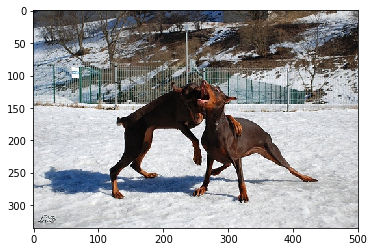

a brown dog is running through the snow .


In [111]:
try_image = images_dir + '/' + test_imgs[0]
plt.imshow(Image.open(try_image))
plt.show()
print (predict_captions(try_image)) 